## Lab 9: Predicting Forest Cover Type with SVMs

### Introduction
In this lab, we will explore the application of Support Vector Machines (SVMs) and Random Forests (RFs) for multi-class classification using cartographic variables. Specifically, we will predict forest cover type based on a variety of environmental features such as elevation, soil type, and land aspect.

Understanding forest cover classification is crucial for natural resource management. Land managers and conservationists rely on accurate predictions of vegetation types to make informed decisions about wildlife habitats, fire management, and sustainable forestry practices. However, direct field assessments of forest cover can be costly and time-consuming, making predictive models a valuable tool for estimating cover types in large or inaccessible regions.

Dataset info here: https://archive.ics.uci.edu/dataset/31/covertype


### Step 0: Load Libraries and Data

In [1]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("covtype_sample.csv")

In [2]:
# First 5 rows of dataframe
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_Rawah,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,3136,228,7,810,-7,6329,210,247,174,1307,...,0,0,0,0,0,0,0,0,0,2
1,2898,129,12,201,4,853,240,233,121,2550,...,1,0,0,0,0,0,0,0,0,2
2,2765,74,16,268,134,2850,237,208,98,6452,...,0,0,0,0,0,0,0,0,0,2
3,3078,189,10,582,-39,2554,221,247,160,1463,...,0,0,0,0,0,0,0,0,0,2
4,3141,159,11,466,-33,1080,231,242,141,1120,...,0,0,0,0,0,0,0,0,0,2


### Step 1: Data Preprocessing 

Before building our classification models, we need to prepare the dataset by separating the features target variable (`Cover_Type`) and  splitting the data into training and test sets. 

We didn't explicitly discuss it in lecture, but SVMs are sensitive to feature scale.  Use `describe()` to summarize the dataset.  Do you see anything that would require scaling of the data?  If so, apply that transformation.

In [3]:
# Summarize the dataset
df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_Rawah,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2955.599500,154.450000,14.114700,268.097600,45.755300,2319.360300,212.19660,223.113500,142.243800,1960.040200,...,0.091200,0.082900,0.00250,0.00250,0.000200,0.000500,0.026800,0.024500,0.013600,2.036600
std,281.786673,111.851861,7.499705,211.899673,58.034207,1548.558651,26.98846,19.871067,37.799752,1320.535941,...,0.287908,0.275745,0.04994,0.04994,0.014141,0.022356,0.161507,0.154603,0.115829,1.383782
min,1860.000000,0.000000,0.000000,0.000000,-164.000000,0.000000,68.00000,71.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2804.750000,58.000000,9.000000,95.000000,7.000000,1091.750000,198.00000,213.000000,119.000000,1006.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2995.000000,126.000000,13.000000,218.000000,29.000000,1977.000000,218.00000,226.000000,142.000000,1699.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3159.000000,258.000000,18.000000,384.000000,68.000000,3279.000000,231.00000,237.000000,168.000000,2524.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3846.000000,359.000000,65.000000,1243.000000,427.000000,7078.000000,254.00000,254.000000,246.000000,7111.000000,...,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [4]:
# Define features and target
X = df.drop(columns=['Cover_Type'])
y = df['Cover_Type']

In [5]:
# Initialize the scaler
scaler = StandardScaler()

# Scale data
df_scaled = scaler.fit_transform(X)

# Convert back to dataframe
X = pd.DataFrame(df_scaled, columns=X.columns)

In [6]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=808)

### Step 2: Hyperparameter Tuning for SVM
To optimize our SVM model, we need to search for the best hyperparameters that maximize classification accuracy. Since SVM performance depends heavily on `C`, `kernel`, and `gamma`, we will use `GridSearchCV()` to systematically test different combinations. Initialize a cross validation object with 5 folds using `StratifiedKFold`. Check out how `StratifiedKFold` differs from `Kfold` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html). 

Then, set up a grid to test different values of: 
- `C` (regularization strength): how strictly the model fits the training data
  - Candidate parameter values: `(0.1, 1, 10, 100)`
- `kernel` (decision boundary shape): compares linear and radial basis function shapes
  - Candidate parameter values: (linear, rbf)
- `gamma` (influence of training observations): influence of individual points on decision boundary
  - Candidate parameter values: (scale, auto)

As models and datasets become more complex, consideration of computation time becomes more important.  You'll use `time.time()` to measure the time required to fit the grid object.  

**Print the best parameters from your model, as well as the time required to fit the grid object.** 

In [7]:
# Initialize cross validation object
stratified_kfold = StratifiedKFold(n_splits=5)

# Set up SVM with RBF kernel and hyperparameter tuning and fit
param_grid_svm = {'C': [0.1, 1, 10, 100],
                  'kernel': ['linear', 'rbf'],
                  'gamma': ['scale', 'auto']}

# Initialize grid search with `StratifiedKFold` cv
grid_search_svm = GridSearchCV(SVC(random_state=808),
                                   param_grid_svm,
                                   cv=stratified_kfold,
                                   n_jobs=-1)

# Start time of fit
start_time = time.time()

# Fit grid object
grid_search_svm.fit(X_train, y_train)

# End time of fit
end_time = time.time()

# Total time to fit
total_time = end_time - start_time

In [8]:
print(f"Best Parameters: {grid_search_svm.best_params_}")
print(f"Time to fit the grid: {total_time:.2f} seconds")

Best Parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Time to fit the grid: 750.72 seconds


### Step 3: Build a fit a Random Forest for comparison

Let's compare our SVM to a Random Forest classifier.  Create a grid for cross-validation with three hyperparameters of your choice to tune, along with three sensible values for each one.  
**Print the best parameters from your model, as well as the time required to fit the grid object.** 

In [9]:
# Train a Random Forest model with hyperparameter tuning and fit
param_grid_rf = {'n_estimators': [10, 50, 100, 2000],
                 'max_depth': [10, 20, 50, None],
                 'max_features': ["sqrt", 9, None]}

# Initialize grid search with `StratifiedKFold` cv
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=808),
                              param_grid_rf,
                              cv=stratified_kfold,
                              n_jobs=-1)

# Start time of fit
start_time_rf = time.time()

# Fit grid object
grid_search_rf.fit(X_train, y_train)

# End time of fit
end_time_rf = time.time()

# Total time to fit
total_time_rf = end_time_rf - start_time_rf

/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [10]:
print(f"Best Parameters: {grid_search_rf.best_params_}")
print(f"Time to fit the grid: {total_time_rf:.2f} seconds")

Best Parameters: {'max_depth': 50, 'max_features': 9, 'n_estimators': 2000}
Time to fit the grid: 174.67 seconds


### Step 4: Model Predictions and Evaluation
Now that you have trained and optimized both a SVM and RF model, you will evaluate their performances on the test set to prepare for model comparison. In this step, you will:
- Use the best models from `GridSearchCV()` to make predictions on the test set
- Generate a confusion matrix for each model to visualize classification performance


In [11]:
# Best SVM model
best_svm = grid_search_svm.best_estimator_
y_test_pred_svm = best_svm.predict(X_test)

# Best RF model
best_rf = grid_search_rf.best_estimator_
y_test_pred_rf = best_rf.predict(X_test)

Text(0.5, 1.0, 'SVM Confusion Matrix')

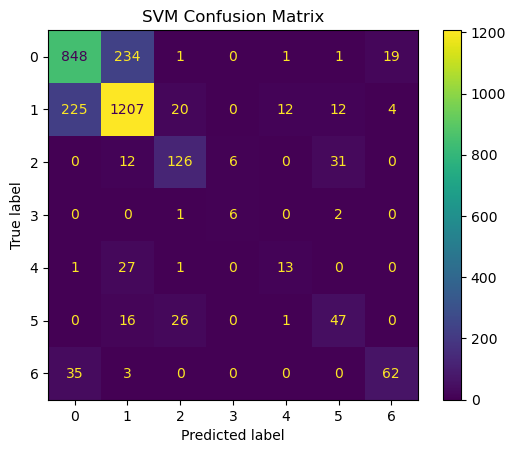

In [12]:
# SVM confusion matrix
svm_matrix = confusion_matrix(y_test, y_test_pred_svm)
svm_display = ConfusionMatrixDisplay(svm_matrix)
svm_display.plot()
plt.title("SVM Confusion Matrix")

Text(0.5, 1.0, 'Random Forest Confusion Matrix')

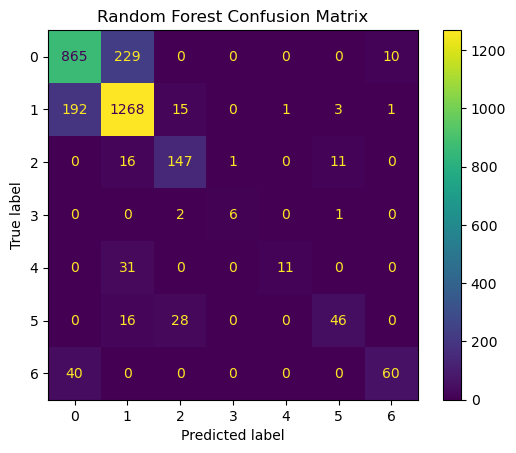

In [13]:
# Random forest confusion matrix
rf_matrix = confusion_matrix(y_test, y_test_pred_rf)
rf_display = ConfusionMatrixDisplay(rf_matrix)
rf_display.plot()
plt.title("Random Forest Confusion Matrix")

### Step 5: Gather and display additional performance metrics
Now display the accuracy score and training time required for each model to so we can compare the models.

In [14]:
# Compute accuracy for both models
test_acc_svm = accuracy_score(y_test, y_test_pred_svm)

test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

print(f"SVM test accuracyy: {test_acc_svm:.2f}, training time: {total_time:.2f} seconds")
print(f"RF test accuracyy: {test_acc_rf:.2f}, training time: {total_time_rf:.2f} seconds")

SVM test accuracyy: 0.77, training time: 750.72 seconds
RF test accuracyy: 0.80, training time: 174.67 seconds


### Step 6: Compare the models
Now that we have trained, optimized, and evaluated both SVM and RF models, we will compare them based on overall accuracy, training time, and types of errors made.

Based on these comparisons, which model is more suitable for this task?  


*Based on the comparisons made above, the RF model is more suitable for this task than the SVM model. While both the SVM and RF models have similar accuracy scores, the RF model has a slightly higher accuracy score. In addition, the RF and SVM models have similar types of errors when looking at both model's confusion matricies. Where the RF model really wins out over the SVM model is in the time it takes to train the models. The SVM model requires a signifciantly longer amount of training time than the RF model.*